<a href="https://colab.research.google.com/github/sipocz/DataMiner/blob/main/Meteo_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Szükséges modulok letöltése

In [1]:
!pip install meteostat
!pip install fitter
!pip install seaborn
!pip install scipy

#modulok importálása

In [2]:
from meteostat import Point
from datetime import datetime
from meteostat import Hourly
import pandas as pd
import seaborn as sns
from fitter import Fitter

In [3]:
Dorog = Point(47.725531, 18.724599) # Dorog GPS koordinátái

In [4]:


# időintervallum
start = datetime(2023, 1, 1)
end = datetime(2024, 9, 24)

# Óránkénti adatokkal dolgozunk
data = Hourly(Dorog, start, end)
data = data.fetch()

# Print Dataframe
print(data)

                     temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                           
2023-01-01 00:00:00   4.6   3.7  94.0   0.0   NaN   50.0   3.6  14.8  1026.5   
2023-01-01 01:00:00   5.1   4.4  95.0   0.0   NaN   80.0   7.2  13.0  1026.3   
2023-01-01 02:00:00   4.4   3.7  95.0   0.0   NaN   50.0   7.2  16.7  1026.6   
2023-01-01 03:00:00   4.2   3.6  96.0   0.0   NaN   60.0   7.2  16.7  1026.8   
2023-01-01 04:00:00   2.7   2.3  97.0   0.0   NaN   90.0   7.2  16.7  1026.4   
...                   ...   ...   ...   ...   ...    ...   ...   ...     ...   
2024-09-23 20:00:00  14.9   8.8  67.0   0.0   NaN  134.0  11.5  14.8  1012.8   
2024-09-23 21:00:00  14.5   8.7  68.0   0.0   NaN  138.0  11.5  13.0  1012.6   
2024-09-23 22:00:00  14.2   8.6  69.0   0.0   NaN  136.0  11.5  14.8  1012.6   
2024-09-23 23:00:00  14.0   8.4  69.0   0.0   NaN  137.0  12.2  16.7  1012.5   
2024-09-24 00:00:00  13.8   8.2  69.0   

#források
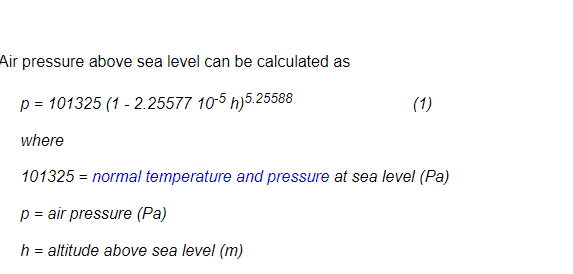

[Képletek forrása](https://colab.research.google.com/drive/1pw62GnlnRAXPxib6stZjr3QB4lpYvcQG#scrollTo=kNgHRyFtqEww&line=1&uniqifier=1)
[Magassági adatok](https://www.magyarorszagterkep.com/magassag)

In [5]:
press=pd.DataFrame(data["pres"]*100) # hektopascal-ban vannak a meteorológiai adatok

In [6]:
press.columns=["meteo"]

In [7]:
press.head()  # nézzük meg mit is kaptunk:

,meteo
time,
2023-01-01 00:00:00,102650.0
2023-01-01 01:00:00,102630.0
2023-01-01 02:00:00,102660.0
2023-01-01 03:00:00,102680.0
2023-01-01 04:00:00,102640.0


In [8]:
press["p_dorog"]=press["meteo"]*(1-(2.25577e-5)*130)**5.25588   # átszámoljuk a tengerszintre konvertált adatokat Dorog tengerszint feletti magasságára

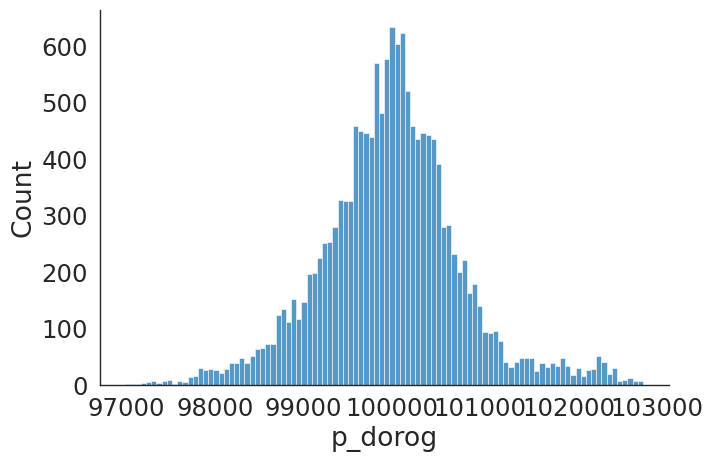

In [9]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=press, x="p_dorog", kind="hist", bins = 100, aspect = 1.5) # nézzünk egy eloszlást

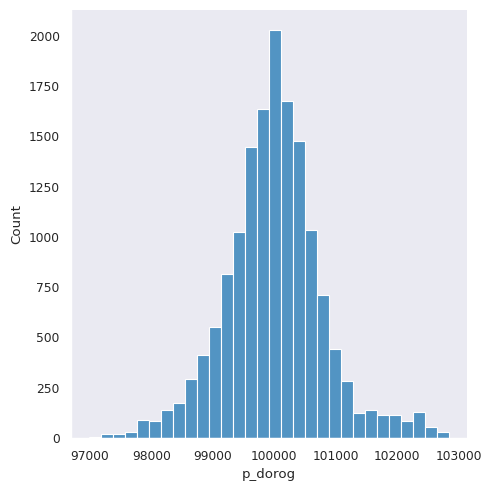

In [10]:
sns.set_style('dark')
sns.set_context("paper", font_scale = 1)
sns.displot(data=press, x="p_dorog", kind="hist", bins = 30, aspect = 1)

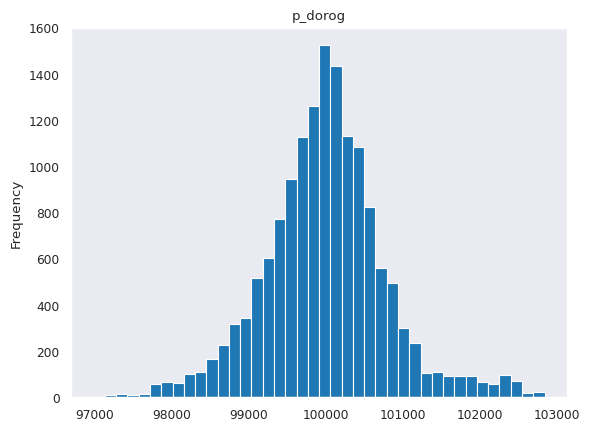

In [11]:
from matplotlib import pyplot as plt
press['p_dorog'].plot(kind='hist', bins=40, title='p_dorog')
plt.gca().spines[['top', 'right',]].set_visible(True)

<Axes: title={'center': 'p_dorog'}, xlabel='time'>

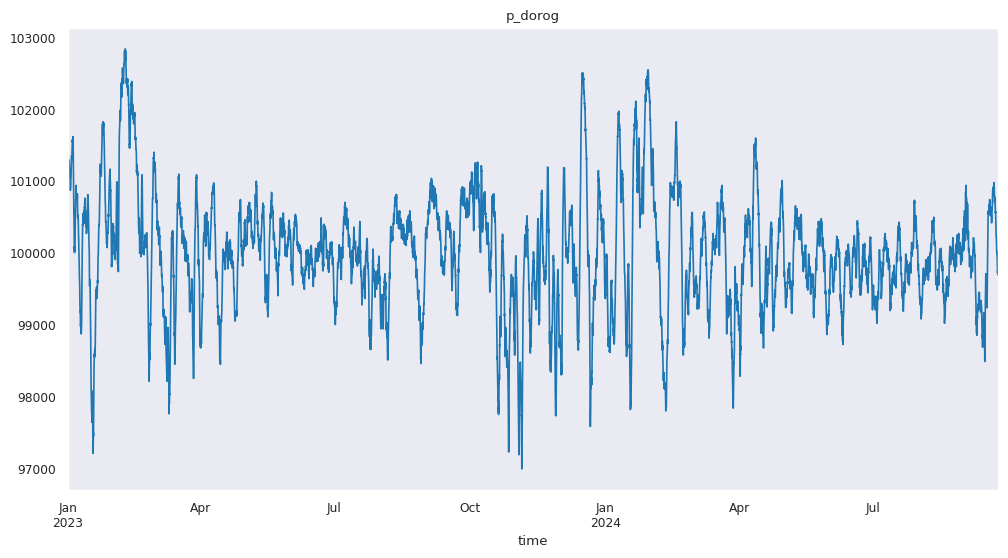

In [12]:
from matplotlib import pyplot as plt
press['p_dorog'].plot(kind='line', figsize=(12, 6), title='p_dorog')


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gennorm,8.020679e-08,1929.405176,1952.286203,0.017034,0.014133,4.623932e-03
norm,3.329082e-07,1973.076892,1988.330911,0.047841,0.052129,2.893313e-36


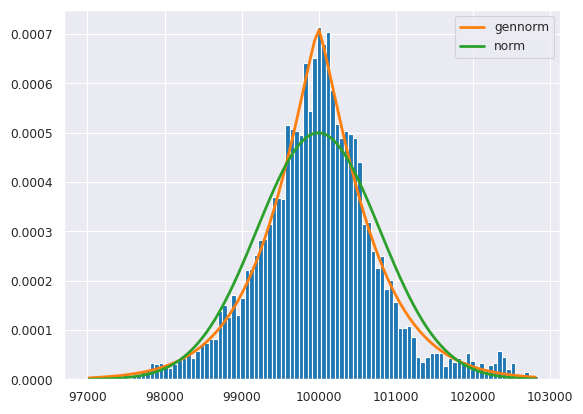

In [13]:
f = Fitter(press["p_dorog"],distributions=["gennorm","norm"])

f.fit()
f.summary()

In [14]:
f.fitted_param["norm"]

(99994.45805813024, 797.7153493080947)

In [15]:
f.fitted_param["gennorm"]

(1.217976706418249, 99994.32624449316, 749.4407678479947)

In [16]:
import scipy

In [17]:
norm=scipy.stats.norm(loc=f.fitted_param["norm"][0], scale=f.fitted_param["norm"][1])
gennorm=scipy.stats.gennorm(loc=f.fitted_param["gennorm"][1], scale=f.fitted_param["gennorm"][2], beta=f.fitted_param["gennorm"][0])

In [18]:
norm.cdf(102000)

0.99403329310753

In [19]:
gennorm.cdf(102000)

0.9877139506738846

Milyen valószínűséggel lesz a nyomás a 1e5 Pa bizinyos intervallumában?


In [20]:
gennorm.cdf(100_000)


0.504034499670794

In [21]:
def val(delta):
    return(gennorm.cdf(100_000+delta)-gennorm.cdf(100_000-delta))

In [22]:
val(2450)

0.990507928806249

In [30]:
result=[]
for test_pos in range(3501):
    if test_pos % 10 == 0:
        print(f"intervallum: {test_pos}, valószínűség: {val(float(test_pos))}")
    result.append([test_pos,val(test_pos)])



intervallum: 0, valószínűség: 0.0
intervallum: 10, valószínűség: 0.014190607570829461
intervallum: 20, valószínűség: 0.028305137407927727
intervallum: 30, valószínűség: 0.04231718442054999
intervallum: 40, valószínűség: 0.056217340934826165
intervallum: 50, valószínűség: 0.06999908301795149
intervallum: 60, valószínűség: 0.08365746951374864
intervallum: 70, valószínűség: 0.09718860216145209
intervallum: 80, valószínűség: 0.11058933661421422
intervallum: 90, valószínűség: 0.12385710595849775
intervallum: 100, valószínűség: 0.13698980346296025
intervallum: 110, valószínűség: 0.14998569990840172
intervallum: 120, valószínűség: 0.16284338264700748
intervallum: 130, valószínűség: 0.17556170909272167
intervallum: 140, valószínűség: 0.18813977022149259
intervallum: 150, valószínűség: 0.20057686126298646
intervallum: 160, valószínűség: 0.21287245771133023
intervallum: 170, valószínűség: 0.2250261953675492
intervallum: 180, valószínűség: 0.23703785350264822
intervallum: 190, valószínűség: 0.248

In [24]:
# 2430 0.9900855723161786
# 3450 0.999002699593029


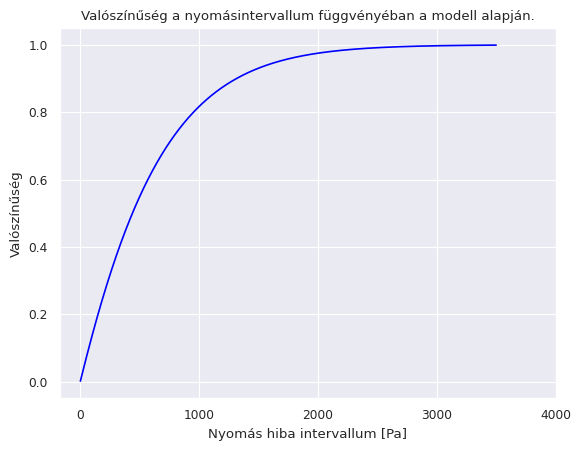

In [25]:
import matplotlib.pyplot as plt
ax=plt.axes()
ax.grid("on")
plt.plot([x[0] for x in result if x[0]>0], [x[1] for x  in result if x[0]>0], color="blue",)
plt.title('Valószínűség a nyomásintervallum függvényéban a modell alapján.')
plt.xlabel('Nyomás hiba intervallum [Pa]')
plt.ylabel('Valószínűség')
plt.box(True)
ax.set_xticks([0,1000,2000,3000,4000])
plt.show()

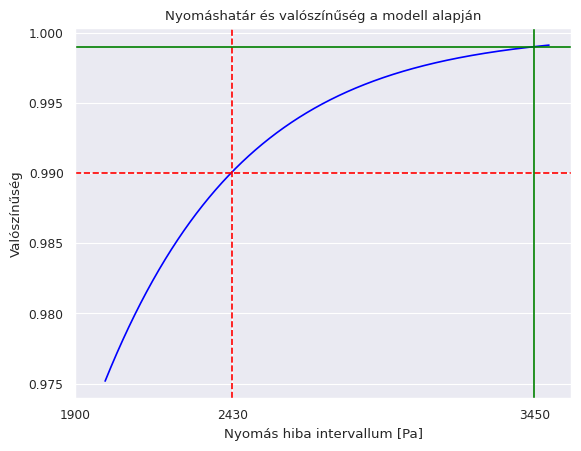

In [29]:
import matplotlib.pyplot as plt
ax=plt.axes()
ax.grid("on")
plt.plot([x[0] for x in result if x[0]>2000], [x[1] for x  in result if x[0]>2000], color="blue",)
plt.title('Nyomáshatár és valószínűség a modell alapján')
plt.xlabel('Nyomás hiba intervallum [Pa]')
plt.ylabel('Valószínűség')
plt.axvline(x=2430, color='r', linestyle='--')
plt.axhline(y=0.99, color='r', linestyle='--')

plt.axvline(x=3450, color='g', linestyle='-')

plt.axhline(y=0.999, color='g', linestyle='-')


ax.set_xticks([1900,2430,3450])
plt.show()

Mit is jelent a 0.99 valószínűség?
Az esetek 99 százalékában 100_000-2_430 Pa és 100_000+2_430 Pa között van a nyomásérték.
Mivel óránként törtánik a nyomásértékek rögzítése így 100 óránként 1 óra értéke tér el. Azaz kb 4 naponként lépünk ki az intervallumból.

Mit jelent 0.999 valószínűség? az esetek 99.9%-ban 100_000-3_450 Pa és 100_000+3_450 Pa között van a nyomás. azaz 1000 óránkét 1 limitsértés történik. 1000 óra az több mint 40 nap. Így évente kb. 9 mérés lesz e határon kívül.

#Nézzük meg ezeket a adatokat a valós méréseken!!

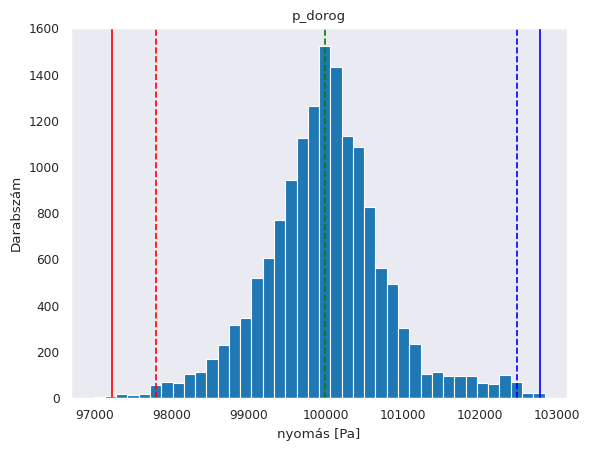

97797.14009173786
102477.5353285122


In [27]:
import matplotlib.pyplot as plt

plt.hist(press['p_dorog'],bins=40)
plt.axvline(x=press['p_dorog'].quantile(0.005), color='r', linestyle='--')
plt.axvline(x=press['p_dorog'].quantile(0.0005), color='r', linestyle='-')

plt.axvline(x=press['p_dorog'].quantile(0.995), color='b', linestyle='--')
plt.axvline(x=press['p_dorog'].quantile(0.9995), color='b', linestyle='-')
plt.axvline(x=press['p_dorog'].quantile(0.5), color='g', linestyle='--')
plt.xticks(rotation=0,)
plt.title('p_dorog')
plt.xlabel('nyomás [Pa]')
plt.ylabel('Darabszám')
plt.show()
print(press['p_dorog'].quantile(0.005))
print(press['p_dorog'].quantile(0.995))


#Eddigi következtetések:


*   Dorogon a légnyomás 99 %-os valószínűséggel 100,000 Pa +-2430 Pa között van az illesztett modell alapján.  
*   Dorogon a légnyomás 99.9%-os valószínűséggel 100,000 PA +-3450 Pa között van az illesztett modell alapján.






#Mit mondhatunk a nyomás mérésekről?

Azok a nyomásmérések amikről most beszélünk (hidrogénezés, autokláv belső nyomásának mérése) jellemzően:
* 0-6 bar nyomástartományban mérnek.
* 1% pontosság jellemző rájuk.
* A pontosságot a méréstartományra szokás megadni.


Így:
6 bar átfogás 6*100,000 Pa=600,000 Pa aminek az 1 %-a 6000 Pa.

A 99%-os valószínűséggel 2430 Pa hibán belül van a légköri nyomás ingadozása. Ez a nyomásmérő hibájánál kisebb.

##következtetés:
Nem okoz hibát ha a légkori nyomást 101325 Pa helyett 100000 Pa-lal helyettesítjük mivel ezzel a kerekítéssel az adott műszerrel megmérhetetlen hibát okozunk.


#VÉGE

In [28]:
stop

NameError: name 'stop' is not defined

In [ ]:
sns.violinplot(press[ 'p_dorog'])


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mintavételezés a 'p_dorog' oszlopból
sample_data = press['p_dorog']

# Boxplot létrehozása seaborn-nal
sns.boxplot(x=sample_data,)
plt.title('Boxplot a p_dorog mintájára')
plt.xlabel('p_dorog')
plt.show()

In [ ]:
press["p_dorog"].describe()

In [ ]:
import statsmodels.api as sm
import numpy as np


ecdf = sm.distributions.ECDF(press['p_dorog'])
x = np.linspace(min(press['p_dorog']), max(press['p_dorog']))
y = ecdf(x)
plt.plot(x, y)
plt.xlabel('p_dorog')
plt.ylabel('ECDF')
plt.show()